### First steps to RCNN (Region-based CNN)

Set-ExecutionPolicy -Scope Process -ExecutionPolicy Bypass

.\packages\Scripts\Activate.ps1

In [1]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
from torchinfo import summary
import cv2

### Model

In [2]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)

summary(model=model,
        input_size=(16, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

d:\Python-codes\packages\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Python-codes\packages\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
FasterRCNN (FasterRCNN)                                 [16, 3, 224, 224]    [0, 4]               --                   Partial
├─GeneralizedRCNNTransform (transform)                  [16, 3, 224, 224]    [16, 3, 800, 800]    --                   --
├─BackboneWithFPN (backbone)                            [16, 3, 800, 800]    [16, 256, 13, 13]    --                   Partial
│    └─IntermediateLayerGetter (body)                   [16, 3, 800, 800]    [16, 2048, 25, 25]   --                   Partial
│    │    └─Conv2d (conv1)                              [16, 3, 800, 800]    [16, 64, 400, 400]   (9,408)              False
│    │    └─FrozenBatchNorm2d (bn1)                     [16, 64, 400, 400]   [16, 64, 400, 400]   --                   --
│    │    └─ReLU (relu)                                 [16, 64, 400, 400]   [16, 64, 400, 400]   --                   --

### Test Data

In [3]:
import requests

url = 'http://images.cocodataset.org/val2017/000000037777.jpg'
response = requests.get(url)

with open('000000037777.jpg', 'wb') as f:
    f.write(response.content)


### Use the model

Number of all classes: 91
10


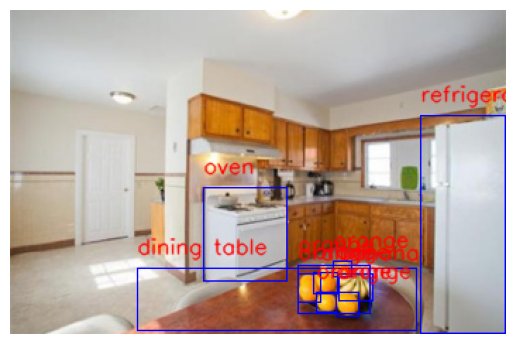

In [4]:
model.eval()

img = Image.open('000000037777.jpg')
transform = transforms.ToTensor()
img = transform(img) #convert to tensor

with torch.no_grad():
  pred = model([img])

coco_names = ["person" , "bicycle" , "car" , "motorcycle" , "airplane" , "bus" , 
"train" , "truck" , "boat" , "traffic light" , "fire hydrant" , "street sign" , 
"stop sign" , "parking meter" , "bench" , "bird" , "cat" , "dog" , "horse" , "sheep", 
"cow" , "elephant" , "bear" , "zebra" , "giraffe" , "hat" , "backpack" , "umbrella", 
"shoe" , "eye glasses" , "handbag" , "tie" , "suitcase" ,
"frisbee" , "skis" , "snowboard" , "sports ball" , "kite" , "baseball bat" ,
"baseball glove" , "skateboard" , "surfboard" , "tennis racket" , "bottle" ,
"plate" , "wine glass" , "cup" , "fork" , "knife" , "spoon" , "bowl" ,
"banana" , "apple" , "sandwich" , "orange" , "broccoli" , "carrot" , "hot dog" ,
"pizza" , "donut" , "cake" , "chair" , "couch" , "potted plant" , "bed" ,
"mirror" , "dining table" , "window" , "desk" , "toilet" , "door" , "tv" ,
"laptop" , "mouse" , "remote" , "keyboard" , "cell phone" , "microwave" ,
"oven" , "toaster" , "sink" , "refrigerator" , "blender" , "book" ,
"clock" , "vase" , "scissors" , "teddy bear" , "hair drier" , "toothbrush" , "hair brush"]
print(f"Number of all classes: {len(coco_names)}")

boxes, labels, scores = pred[0]['boxes'], pred[0]['labels'], pred[0]['scores']

# print(torch.argwhere(scores > 0.8)) # indexes
num = len(torch.argwhere(scores > 0.8))
print(num)


new_img = cv2.imread('000000037777.jpg')
for i in range(num):
  x1, y1, x2, y2 = boxes[i].numpy().astype('int')
  class_name = coco_names[labels.numpy()[i] - 1]
  new_image = cv2.rectangle(new_img, (x1, y1), (x2, y2), (255, 0, 0), 1)
  new_image = cv2.putText(new_img, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)

new_img_rgb = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)

# Plot the image using matplotlib
plt.imshow(new_img_rgb)
plt.axis('off')  # Hide axes for a cleaner look
plt.show()

In [5]:

# Prepare the model
model.eval()
transform = transforms.ToTensor()

# Initialize video capture (0 is typically the default webcam)
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not open camera.")
    exit()

# Main loop
while True:
    ret, frame = cap.read()
    if not ret:
        print("Error: Could not read frame.")
        break
    
    # Convert frame to PIL Image and then to tensor
    pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    img_tensor = transform(pil_image)
    
    # Perform inference
    with torch.no_grad():
        pred = model([img_tensor])
    
    boxes, labels, scores = pred[0]['boxes'], pred[0]['labels'], pred[0]['scores']
    
    # Filter predictions with scores > 0.8
    for i in range(len(scores)):
        if scores[i] > 0.8:
            x1, y1, x2, y2 = boxes[i].numpy().astype('int')
            class_name = coco_names[labels[i] - 1]
            
            # Draw rectangle and label on the frame
            cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(frame, f"{class_name}: {scores[i]:.2f}", (x1, y1 - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    # Display the frame
    cv2.imshow('Real-Time Object Detection', frame)
    
    # Exit on pressing 'q'
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()